In [1]:
from baseline.main_model import *
import pandas as pd
import numpy as np
import os
import copy  
import json
import pickle
from tqdm import tqdm
from matplotlib import pyplot as plt


In [2]:
pd.options.display.float_format = '{:.4f}'.format

# Testing 

In [3]:
def agg_intraday_daily(intraday_data, daily_data):
    '''Aggregate intraday and daily data for a specific symbol.'''
    intraday_data, daily_data = eliminate_half_days(intraday_data, daily_data)
    daily_data['daily_vol_pct'] = daily_data['total_vol_m'].rank(pct=True)
    df = intraday_data.merge(daily_data[['DATE', 'symbol', 'total_vol_m', 'overnight_gap', 'daily_vol_pct']], how='left', left_on=['date', 'symbol'],
                     right_on=['DATE', 'symbol'])
    df.index = pd.DatetimeIndex(df['datetime'])
    df['time'] = df.index.time
    df.drop(columns=['DATE', 'datetime'], inplace=True)
    df = df.between_time('09:31:00', '15:59:00')
    df['%_vol'] = df['size'] / df['total_vol_m']
    df = df.drop('sym_suffix', 1)  #add new line
    return df

# Whole Russell

In [4]:
path = '/Users/Mason/Desktop/Volatility/russell'
data_paths = [os.path.join(path, f) for f in os.listdir(path)]

In [5]:
r_1000 = '/Users/Mason/Desktop/Volatility/russell/Russell_1000.txt'
r_2000 = '/Users/Mason/Desktop/Volatility/russell/Russell_2000.txt'
r_sample = '/Users/Mason/Desktop/Volatility/russell/Russell_Sample.txt'

data_paths.remove(r_1000)
data_paths.remove(r_2000)
data_paths.remove(r_sample)

In [6]:
def prep_data(csv_file,date):
    df = pd.read_csv(csv_file)
    df_sample = copy.deepcopy(df)
    df['time']  = pd.to_timedelta(df['time'])
    df['date'] = pd.to_datetime(df['date'])# format='%Y%m%d')
    df = df[df['date'] == str(date)]
    df_sample = df_sample[df_sample['date'] == str(date)]
    df_sample['datetime'] = df['date'] + df['time']
    df_sample = df_sample.set_index('datetime')
    df_sample['time'] = pd.to_datetime(df_sample['time']).dt.strftime('%H:%M:%S')
    df_sample = df_sample.between_time('9:45:00','15:55:00')
    return df_sample

In [7]:
# # loop over the list of csv files

# day_est = [{} for i in range(len(days))]
# day_real = [{} for i in range(len(days))]

# for f in tqdm(data_paths[:]):
#     date='2021-09-01'
#     date = datetime.strptime(date, '%Y-%m-%d').date()
#     df_sample = prep_data(f, date)
#     intraday_file = f
#     daily_file = '/Users/Mason/Desktop/Volatility/russell_daily.csv'
#     ticker = df_sample.sym_root.unique()[0]
        
#     daily_data, intraday_data, overnight_gap = clean_data(intraday_file, daily_file, ticker, date)
#     historical = agg_intraday_daily(intraday_data, daily_data)
#     estimated_daily = DailyModel(daily_data)
#     coef = regress_volume(historical)
#     estimated_intraday = predict_intraday(coef, historical, estimated_daily, overnight_gap)
#     estimated_intraday = estimated_intraday.sort_index()
#     estimation = pd.DataFrame({'time':estimated_intraday[14:-4].index, 'est':estimated_intraday[14:-4].values})

#     russell_est[ticker] = estimation
#     russell_real[ticker] = df_sample[['time', 'size']]




In [8]:
day_loop = pd.read_csv('time_1.csv',header=None)

In [9]:
day_loop

,0
0,2021-09-01
1,2021-09-02
2,2021-09-03
3,2021-09-06
4,2021-09-07
...,...
85,2021-12-27
86,2021-12-28
87,2021-12-29
88,2021-12-30


In [10]:

days = day_loop.values.tolist()
day_est = [{} for i in range(len(days))]
day_real = [{} for i in range(len(days))]

# score_baseline = [{} for i in range(len(days))]


for f in tqdm(data_paths[:]):
    for d in range(90):
        try:
            date = day_loop.iloc[d,0]
            date = datetime.strptime(date, '%Y-%m-%d').date()
            
            df_sample = prep_data(f, date)
           
            intraday_file = f
           
            daily_file = '/Users/Mason/Desktop/Volatility/russell_daily.csv'
            ticker = df_sample.sym_root.unique()[0]
          
            daily_data, intraday_data, overnight_gap = clean_data(intraday_file, daily_file, ticker, date)
            
            historical = agg_intraday_daily(intraday_data, daily_data)
            estimated_daily = DailyModel(daily_data)
            coef = regress_volume(historical)
            estimated_intraday = predict_intraday(coef, historical, estimated_daily, overnight_gap)
            estimated_intraday = estimated_intraday.sort_index()
            estimation = pd.DataFrame({'time':estimated_intraday[14:-4].index, 'est':estimated_intraday[14:-4].values})
            
           
            day_est[d][ticker] = estimation
            day_real[d][ticker] = df_sample[['time', 'size']]
          
            
            # score_baseline[d][ticker] = np.abs(df_sample['size']-estimation)/df_sample['size']
        

        except:
            pass

 71%|███████   | 79/112 [12:24:03<1:30:47, 165.07s/it]  

In [ ]:
day_mean_baseline = []
for i in range(len(score_baseline)):
    if len(score_baseline[i].values()) ==0:
        day_mean_baseline.append(0)
    else:
        day_mean_baseline.append(sum(score_baseline[i].values())/len(score_baseline[i].values()))
day_mean_baseline

[     2021-09-01 09:45:00  2021-09-01 09:46:00  2021-09-01 09:47:00  \
 0                    NaN                  NaN                  NaN   
 1                    NaN                  NaN                  NaN   
 2                    NaN                  NaN                  NaN   
 3                    NaN                  NaN                  NaN   
 4                    NaN                  NaN                  NaN   
 ..                   ...                  ...                  ...   
 366                  NaN                  NaN                  NaN   
 367                  NaN                  NaN                  NaN   
 368                  NaN                  NaN                  NaN   
 369                  NaN                  NaN                  NaN   
 370                  NaN                  NaN                  NaN   
 
      2021-09-01 09:48:00  2021-09-01 09:49:00  2021-09-01 09:50:00  \
 0                    NaN                  NaN                  NaN   
 1  

In [ ]:
pd.DataFrame({'date':days,'day_mean_baseline':day_mean_baseline})

,date,day_mean_baseline
0,[2021-09-01],2021-09-01 09:45:00 2021-09-01 09:46:00 ...
1,[2021-09-02],2021-09-02 09:45:00 2021-09-02 09:46:00 ...
2,[2021-09-03],2021-09-03 09:45:00 2021-09-03 09:46:00 ...
3,[2021-09-06],0
4,[2021-09-07],2021-09-07 09:45:00 2021-09-07 09:46:00 ...
...,...,...
85,[2021-12-27],2021-12-27 09:45:00 2021-12-27 09:46:00 ...
86,[2021-12-28],2021-12-28 09:45:00 2021-12-28 09:46:00 ...
87,[2021-12-29],2021-12-29 09:45:00 2021-12-29 09:46:00 ...
88,[2021-12-30],2021-12-30 09:45:00 2021-12-30 09:46:00 ...


In [ ]:
day_mean_pvm  = pd.read_csv('day_mean_pvm.csv')

## Save in Pickle

In [ ]:

# create a binary pickle file 
f = open("russell_baseline.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(russell_est,f)

# close file
f.close()

NameError: name 'russell_est' is not defined

In [ ]:
f = open("russell_size.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(russell_real,f)

# close file
f.close()

In [ ]:
file_to_read = open("russell_baseline.pkl", "rb")
loaded_dictionary = pickle.load(file_to_read)
loaded_dictionary

{'SR':          time       est
 0    09:45:00 1482.0000
 1    09:46:00 1412.0000
 2    09:47:00 1139.0000
 3    09:48:00 1109.0000
 4    09:49:00 1147.0000
 ..        ...       ...
 366  15:51:00 4233.0000
 367  15:52:00 4525.0000
 368  15:53:00 4447.0000
 369  15:54:00 5963.0000
 370  15:55:00 6613.0000
 
 [371 rows x 2 columns],
 'ELS':          time       est
 0    09:45:00  726.0000
 1    09:46:00  738.0000
 2    09:47:00  749.0000
 3    09:48:00  732.0000
 4    09:49:00  709.0000
 ..        ...       ...
 366  15:51:00 2981.0000
 367  15:52:00 3223.0000
 368  15:53:00 3514.0000
 369  15:54:00 3941.0000
 370  15:55:00 4431.0000
 
 [371 rows x 2 columns],
 'MOV':          time       est
 0    09:45:00  338.0000
 1    09:46:00  375.0000
 2    09:47:00  384.0000
 3    09:48:00  384.0000
 4    09:49:00  414.0000
 ..        ...       ...
 366  15:51:00 1451.0000
 367  15:52:00 1559.0000
 368  15:53:00 1584.0000
 369  15:54:00 1724.0000
 370  15:55:00 1989.0000
 
 [371 rows x 2 columns],

## Metrics Evaluation

In [ ]:
def find_metrics(data):
    abs_val = np.abs(data['residual'].values)/ data['size'].values
    return np.sum(abs_val)/len(abs_val)

In [ ]:
error_dict = {}
for i in tqdm(russell_est.keys()):
    if len(russell_est[i]) == 0:
        pass
    else:
        russell_est[i]['time'] = russell_est[i]['time'].astype(str)
        russell_real[i]['time'] =  russell_real[i]['time'].astype(str)
        new_df = pd.merge(russell_est[i], russell_real[i], how = 'inner', on = 'time')
        new_df['residual'] = new_df['size'] - new_df['est']
        error_dict[i] = new_df

100%|██████████| 107/107 [00:00<00:00, 447.58it/s]


In [ ]:
f = open("russell_residual.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(error_dict,f)

# close file
f.close()

In [ ]:
metrics_dict = {}
for j in error_dict.keys():
    result = find_metrics(error_dict[j])
    metrics_dict[j] = result

In [ ]:
f = open("russell_base_metrics.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(metrics_dict,f)

# close file
f.close()

In [ ]:
name = list(metrics_dict.keys())
score = list(metrics_dict.values())

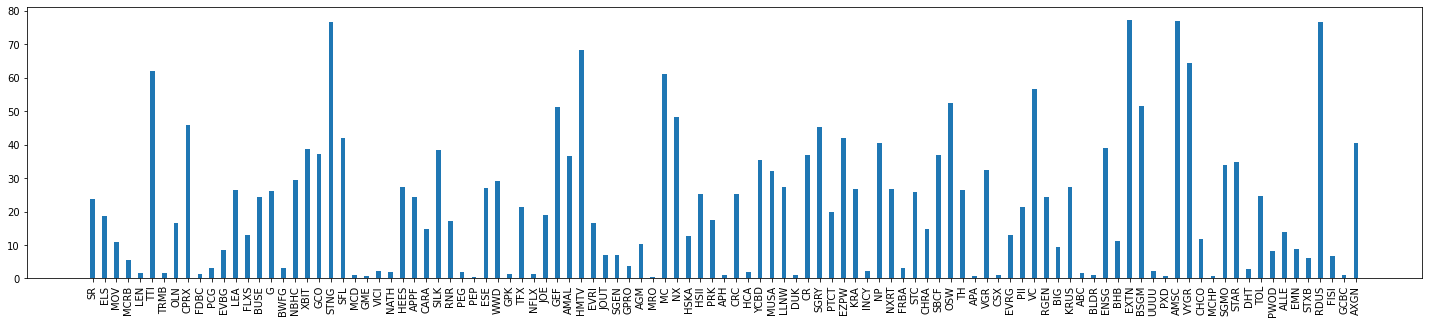

In [ ]:
fig = plt.figure(figsize =(25, 5))
plt.bar(name, score,
        width = 0.4)
plt.xticks(rotation = 90)
plt.show()